In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import artm
# check 
#artm.version()

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

важно, сколько раз слово встретилось, не важенн порядок
в документ могут входить элементы других классов, модальностей(например хештеги)
vowpal_wabbit - текст, строчка - документ. \
название|text слова
text - название модальности
может стоять слово:кол-во раз, встретилось
батчи - несколько отдельных файлов, в каждом по bach_size документов
target_folder - cоздает папку, где хранить батчи

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit"
                                        , target_folder="school_batches", batch_size=100)

OSError: [WinError 126] Не найден указанный модуль
Failed to load artm shared library from `['artm.dll', 'C:\\BigARTM\\Python\\artm\\wrapper\\..\\artm.dll']`. Try to add the location of `artm.dll` file into your PATH system variable, or to set ARTM_SHARED_LIBRARY - the specific system variable which may point to `artm.dll` file, including the full path.


В следующий раз данные можно считывать уже из батчей:

In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

In [4]:
#Создаем объект модели:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [5]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [6]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                          # use_unigram_document_model=False,
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

меньше перплексия - лучше
SparsityPhiScore - метрики разреженности матриц фи и тетта

если слово входит в небольше колво тем,1-2, то матрица фи будет разреженной
если документ к одной-2 темам, то много нулей. тоже разженная(тетта)
чем больше разр - тем лучше

top_words - топы слов, которые входят в темы. чтобы интерпретировать

In [7]:
#Инициализируем модель с помощью созданного ранее словаря
model_artm.initialize(dictionary=dictionary)



Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.
когда большая - онлайн, но надо настраивать другие прараметры

In [8]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)
#num_document_passes столько раз по каждому документу

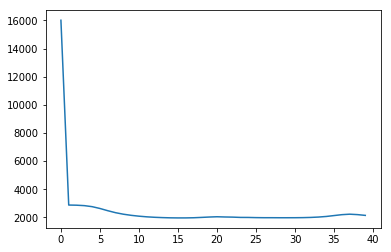

In [9]:
#Необходимое число итераций можно отслеживать по графику перплексии.
#Когда она перестала меняться, модель сошла. value - хранит историю. last - последний
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

In [10]:
model_artm.score_tracker["top_words"].last_tokens

{'sbj0': ['который',
  'быть',
  'что',
  'это',
  'этот',
  'человек',
  'как',
  'свой',
  'для',
  'они',
  'его',
  'весь',
  'такой',
  'время',
  'год'],
 'sbj1': ['y',
  'x',
  'a',
  'многочлен',
  'b',
  'выражение',
  'квадрат',
  'множитель',
  'скобка',
  'умножение',
  'функция',
  'целый',
  'f',
  'симметричный',
  'разность'],
 'sbj2': ['обособление',
  'куприн',
  'слово',
  'раскольников',
  'мастер',
  'роман',
  'словосочетание',
  'маргарита',
  'подчинительный',
  'соня',
  'вера',
  'оборот',
  'браслет',
  'старик',
  'сантьяго'],
 'sbj3': ['год',
  'государство',
  'свой',
  'время',
  'который',
  'быть',
  'северный',
  'война',
  'становиться',
  'мир',
  'россия',
  'страна',
  'территория',
  'африка',
  'развитие'],
 'sbj4': ['x',
  'a',
  'b',
  'уравнение',
  'дробь',
  'y',
  'квадратный',
  'степень',
  'функция',
  'число',
  'f',
  'корень',
  'решение',
  'c',
  'пример'],
 'sbj5': ['быть',
  'пушкин',
  'год',
  'свой',
  'его',
  'империя',
  'тр

In [11]:
#топы слов
# tokens from last update of Phi
saved_top_tokens = model_artm.score_tracker['top_words'].last_tokens
# print top tokens
for topic_name in model_artm.topic_names:
    print (topic_name, ', '.join([x for x in saved_top_tokens[topic_name]]))

sbj0 который, быть, что, это, этот, человек, как, свой, для, они, его, весь, такой, время, год
sbj1 y, x, a, многочлен, b, выражение, квадрат, множитель, скобка, умножение, функция, целый, f, симметричный, разность
sbj2 обособление, куприн, слово, раскольников, мастер, роман, словосочетание, маргарита, подчинительный, соня, вера, оборот, браслет, старик, сантьяго
sbj3 год, государство, свой, время, который, быть, северный, война, становиться, мир, россия, страна, территория, африка, развитие
sbj4 x, a, b, уравнение, дробь, y, квадратный, степень, функция, число, f, корень, решение, c, пример
sbj5 быть, пушкин, год, свой, его, империя, трение, поэт, русский, характер, функция, ребенок, язык, звук, существительное
sbj6 сила, тело, энергия, поле, географический, наречие, частица, ядерный, заряд, величина, контур, площадь, вода, вещество, экологический
sbj7 который, что, быть, это, как, человек, для, этот, такой, свой, являться, мочь, себя, они, весь
sbj8 быть, который, что, это, свой, это

In [12]:
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)
#cколько нулей

0.732406735420227
0.12210526317358017


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

если задаем название словаря в регуляризаторе, то коэфф будет умножаться на частоту слова во всей коллекции, т.е суммарно значения будут не оч большие\
если не указываем словарь, то регуляризация будет для каждого слова одинакова, тогда кофф -2 - -5

In [13]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [14]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [15]:
model_artm.score_tracker['top_words'].last_tokens['sbj6']

['наречие',
 'be',
 'оборот',
 'примыкать',
 'прилагательное',
 'действие',
 'местоимение',
 'прилагательный',
 'разряд',
 'муж',
 'существительный',
 'король',
 'not',
 'ещ',
 'красивый']

In [17]:

# check tokens after tau regularizer change
# tokens from last update of Phi
saved_top_tokens = model_artm.score_tracker['top_words'].last_tokens
# print top tokens
print(saved_top_tokens)
    
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)
#cколько нулей

{'sbj0': ['быть', 'который', 'этот', 'время', 'год', 'государство', 'что', 'они', 'для', 'весь', 'x', 'вода', 'первый', 'также', 'русский'], 'sbj2': ['обособление', 'слово', 'куприн', 'раскольников', 'мастер', 'роман', 'словосочетание', 'маргарита', 'подчинительный', 'браслет', 'соня', 'вера', 'управление', 'зависимое', 'княгиня'], 'sbj3': ['который', 'быть', 'год', 'этот', 'для', 'государство', 'время', 'весь', 'они', 'свой', 'что', 'также', 'становиться', 'мир', 'первый'], 'sbj4': ['x', 'a', 'b', 'уравнение', 'число', 'корень', 'дробь', 'функция', 'y', 'степень', 'квадратный', 'решение', 'f', 'получать', 'пример'], 'sbj5': ['быть', 'функция', 'пушкин', 'трение', 'предложение', 'точка', 'год', 'f', 'империя', 'звук', 'существительное', 'язык', 'пример', 'падеж', 'a'], 'sbj6': ['наречие', 'be', 'оборот', 'примыкать', 'прилагательное', 'действие', 'местоимение', 'прилагательный', 'разряд', 'муж', 'существительный', 'король', 'not', 'ещ', 'красивый'], 'sbj7': ['что', 'человек', 'это', 'к


Попробуем менять коэффициент регуляризаци

In [18]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [19]:
%%time
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Wall time: 3.32 s


In [20]:
saved_top_tokens = model_artm.score_tracker['top_words'].last_tokens


# еще раз посмотрим на разреженность
print (model_artm.score_tracker["SparsityPhiScore"].last_value)
print (model_artm.score_tracker["SparsityThetaScore"].last_value)

0.9103171825408936
0.5088421106338501


In [21]:
saved_top_tokens

{'sbj0': ['вода',
  'корень',
  'древний',
  'y',
  'f',
  'квадратный',
  'дом',
  'n',
  'океан',
  'александр',
  'очередь',
  'течение',
  'хорошо',
  'среди',
  'предприятие'],
 'sbj3': ['северный',
  'африка',
  'зона',
  'ресурс',
  'географический',
  'конфликт',
  'климат',
  'международный',
  'ядерный',
  'цивилизация',
  'материк',
  'остров',
  'организация',
  'карта',
  'наречие'],
 'sbj5': ['пушкин',
  'империя',
  'восстание',
  'трение',
  'существительное',
  'английский',
  'пояс',
  'павел',
  'падеж',
  'оборот',
  'is',
  'дорога',
  'слабый',
  'плазма',
  'are'],
 'sbj7': ['общество',
  'герой',
  'чтобы',
  'сам',
  'отношение',
  'политический',
  'социальный',
  'понятие',
  'лермонтов',
  'через',
  'понимать',
  'собственный',
  'помощь',
  'жить',
  'сфера'],
 'sbj8': ['x',
  'a',
  'два',
  'b',
  'ребенок',
  'город',
  'равный',
  'уравнение',
  'сторона',
  'движение',
  'условие',
  'различный',
  'поле',
  'семья',
  'чувство'],
 'sbj9': ['который',

Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [ ]:

model_artm.save("my_model")

In [ ]:
model_artm.load("my_model")

In [22]:

phi = model_artm.get_phi()
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
домохозяйка,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000011
институт,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.001554,0.000000
машинка,0.000000,0.0,0.0,0.000000,0.0,0.000160,0.0,0.000000,0.000000,0.000000
прочий,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000668,0.000000,0.000000
навязнуть,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000263,0.000000,0.000000
физиология,0.000000,0.0,0.0,0.000000,0.0,0.000479,0.0,0.000000,0.000000,0.000000
истязать,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000050,0.000000
выборы,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000902,0.000000
кндр,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000034
федерализм,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000050,0.000000


In [23]:
theta = model_artm.get_theta()
theta

,100,101,102,103,104,105,106,107,108,109,...,390,391,392,393,394,395,396,397,398,399
sbj0,0.033639,0.073171,0.007772,0.059322,0.142384,0.013783,0.141566,0.070539,0.051195,0.013514,...,0.190939,0.140212,0.324400,0.391043,0.392678,0.519757,0.338710,0.165468,0.222746,0.420454
sbj1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj3,0.024465,0.293624,0.010363,0.362296,0.055654,0.012251,0.060241,0.029046,0.000000,0.016892,...,0.003236,0.005291,0.000000,0.005587,0.020290,0.011628,0.026882,0.039568,0.005319,0.127841
sbj4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj5,0.012432,0.097561,0.005181,0.008475,0.023179,0.044410,0.030121,0.062241,0.023891,0.000000,...,0.019417,0.007937,0.010005,0.027951,0.002899,0.064546,0.005376,0.053957,0.011296,0.045455
sbj6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj7,0.173783,0.000000,0.379023,0.029661,0.069505,0.314735,0.078285,0.170092,0.020478,0.293919,...,0.143759,0.121394,0.106907,0.078212,0.095652,0.031977,0.032258,0.068237,0.079787,0.022727
sbj8,0.040085,0.125436,0.051838,0.097458,0.109304,0.058875,0.069306,0.074721,0.221843,0.057433,...,0.080906,0.087302,0.116275,0.055866,0.056598,0.037791,0.104839,0.086439,0.212766,0.073864
sbj9,0.715596,0.410208,0.545823,0.442788,0.599975,0.555945,0.620481,0.593361,0.682593,0.618243,...,0.561742,0.637865,0.442413,0.441341,0.431884,0.334302,0.491936,0.586331,0.468085,0.309659


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [ ]:
theta_test = model_artm.transform(batch_vectorizer)